In [1]:
library(jsonlite)
library(plyr)
library(dplyr)
library(ggplot2)

Warning message:
“package ‘jsonlite’ was built under R version 3.3.3”Warning message:
“package ‘plyr’ was built under R version 3.3.3”Warning message:
“package ‘dplyr’ was built under R version 3.3.3”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
setwd("/home/hduser1/Yelp")
biz_food = stream_in(file("biz_food_clustered.json"))
review = stream_in(file("review.json"))
review_food = review[which(review$business_id %in% biz_food$business_id),]

opening file input connection.


 Imported 9857 records. Simplifying...


closing file input connection.
opening file input connection.


 Imported 4153150 records. Simplifying...


closing file input connection.


In [3]:
review_food = left_join(review_food, biz_food[,c("business_id","state")], by = "business_id")
revByState = split(review_food, f=review_food$state)

In [4]:
survivalData = read.csv(file = "survivalData10.csv")
survivalData = survivalData[,c("business_id", "dF", "avgDB")]
biz_food = left_join(biz_food, survivalData, by = "business_id")
biz_food$opened = as.Date("2017-01-20") - biz_food$dF
bizByState = split(biz_food, f=biz_food$state)

Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”

In [5]:
states = unique(biz_food$state)

In [6]:
# find appropriate threshold for each state
thresholds = sapply(states, function(st){
  i = which(states == st)
  biz = bizByState[[i]]
  numRev = c(3:52)
  percentOpen = sapply(numRev, function(n){
    open = biz[which(biz$review_count >= n & biz$is_open == 1),]
    closed = biz[which(biz$review_count >= n & biz$is_open == 0),]
    return(nrow(open)/(nrow(open) + nrow(closed)))
  })
  rSquared = sapply(c(1:50), function(n){
    x = c(3:(2+n))
    y = percentOpen[1:n]
    # best model to consider?
    invModel = lm(1/y ~ x)
    return(summary(invModel)$r.squared)
  })
  rSquared[rSquared == 1] = 0
  j = which(rSquared == max(rSquared))
  return(numRev[j])
})

In [7]:
thresholds

AZ NC NV OH ON PA QC WI 
17 19 41 45 38 14 16  8

In [8]:
revPerDay = lapply(states, function(st){
  i = which(states == st)
  rev = revByState[[i]]
  
  perDay = plyr::count(rev, "date")
  perDay$date = as.Date(perDay$date)
  perDay$day = as.numeric(perDay$date - min(perDay$date)) + 1
  perDay$daydiff = c(0, diff(perDay$day))
  cutoff = max(perDay$date[which(perDay$daydiff > 1)])
  perDay = perDay[which(perDay$date >= cutoff),]
  perDay$day = as.numeric(perDay$date - cutoff) + 1
  
  x = perDay$day
  y = perDay$freq
  polyModel = lm(y ~ I(x)+I(x^2)+I(x^2*sin(2*x*pi/7))+I(x^2*sin(2*x*pi/182.5))+I(x^2*sin(2*x*pi/365)), data = perDay)
  perDay$fitted = predict(polyModel, data = perDay)
  
  perDay$fitdiff = c(0, diff(perDay$fitted))
  perDay$area = 0.5*(2*perDay$fitted - perDay$fitdiff)
  perDay$cumarea = cumsum(perDay$area)
  
  return(perDay)
})

In [9]:
cutoff = sapply(states, function(st){
  i = which(states == st)
  rev = revByState[[i]]
  
  perDay = plyr::count(rev, "date")
  perDay$date = as.Date(perDay$date)
  perDay$day = as.numeric(perDay$date - min(perDay$date)) + 1
  perDay$daydiff = c(0, diff(perDay$day))
  cutoff = max(perDay$date[which(perDay$daydiff > 1)])
  
  return(cutoff)
})

cutoff = as.Date(cutoff, origin = as.Date("1970-01-01"))

In [10]:
cutoff

AZ           NC           NV           OH           ON           PA 
"2007-12-23" "2010-12-27" "2007-04-21" "2011-11-25" "2008-12-27" "2014-01-13" 
          QC           WI 
"2012-04-22" "2014-12-26"

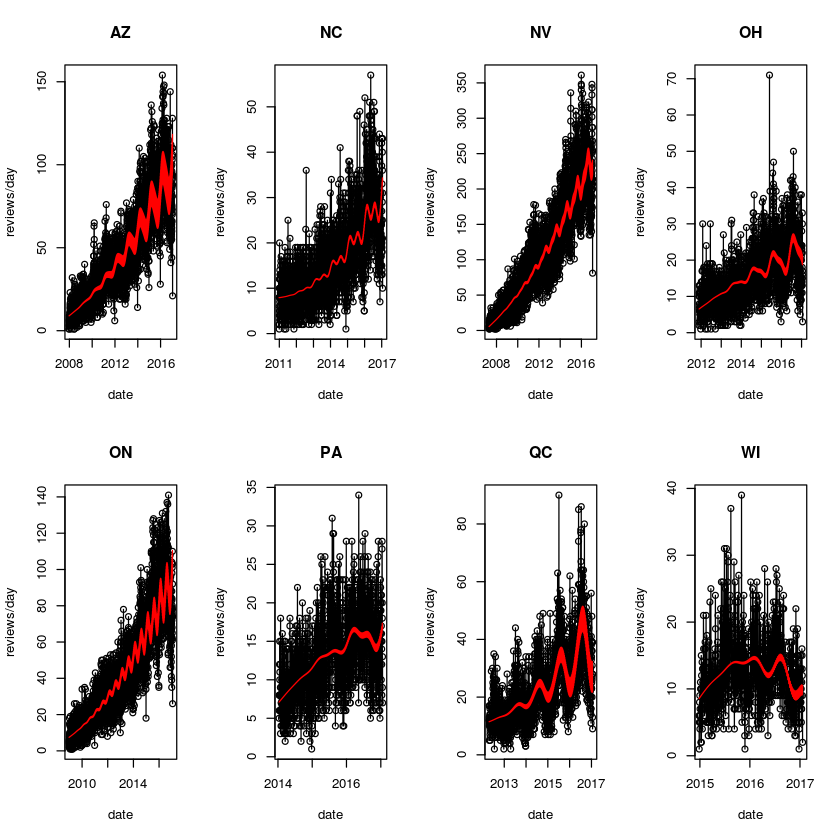

In [11]:
par(mfrow = c(2,4))
for (i in 1:8){
  df = revPerDay[[i]]
  plot(df$date, df$freq, type = "o", xlab="date", ylab="reviews/day", main=states[i])
  lines(df$date, df$fitted, lwd=1, col = "red")
}

In [12]:
# add counters to individual reviews
revByState2 = lapply(states, function(st){
  i = which(states == st)
  rev = revByState[[i]]
  rev = rev[which(rev$date >= cutoff[st]),]
  rev = rev[with(rev, order(rev$business_id, rev$date)),]
  counts = plyr::count(rev, "business_id")
  counter = lapply(counts$freq, function(x) {
    return(c(1:x))
  }) 
  counter = unlist(counter)
  rev$counter = counter
  return(rev)
})

In [13]:
bizByState2 = lapply(states, function(st){
  i = which(states == st)
  biz = bizByState[[i]]
  rev = revByState2[[i]]
  perDay = revPerDay[[i]]
  
  biz = biz[which(biz$opened >= cutoff[st]),]
  targetThresh = thresholds[st]
  
  expNumDays = function(dateOpened){
    day = as.numeric(as.Date(dateOpened) - as.Date(cutoff[st]) + 1)
    targetArea = perDay$cumarea[day] + targetThresh*nrow(biz)
    vec = abs(perDay$cumarea - targetArea)
    return(median(which(vec == min(vec))) - day)
  }
  
  reached = rev[which(rev$counter == thresholds[st]), c("business_id", "date")]
  reached = left_join(reached, survivalData[,c(1:2)], by = "business_id")
  colnames(reached)[2:3] = c("reached","opened")
  reached$opened = as.Date("2017-01-20") - reached$opened
  reached$daysToThresh = as.numeric(as.Date(reached$reached) - reached$opened)
  biz = left_join(biz, reached[,c(1,2,4)], by = "business_id")
  
  biz$expDays = sapply(biz$opened, expNumDays)
  biz$reachedThresh = biz$reached <= biz$expDays
  
  return(biz)
})

Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”Warnin

In [14]:
biz_poisson = do.call("rbind", bizByState2)